# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import librosa as lb
import IPython.display as ipd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

In [2]:
metadata = pd.read_csv('./m_metadata.csv')
print(metadata.shape)
metadata.head()

(216, 3)


,Sample,Class_ID,Class
0,./input/notes_v2/A/A1.wav,1,A
1,./input/notes_v2/A/A1.wav_000.wav,1,A
2,./input/notes_v2/A/A1.wav_010.wav,1,A
3,./input/notes_v2/A/A2.wav,1,A
4,./input/notes_v2/A/A2.wav_001.wav,1,A


In [3]:
classes = metadata.groupby('Class_ID')['Class'].unique()
classes

Class_ID
1           [A]
2           [B]
3           [C]
4           [D]
5           [E]
6           [F]
7           [G]
8      [Barrel]
9       [Flage]
10    [PoffHon]
11       [Slap]
12      [Slide]
Name: Class, dtype: object

In [4]:
def feature_exctractor(path: str) -> np.array:
    data, sample_rate = lb.load(path)
    data = lb.feature.mfcc(data, n_mfcc=128)
    data= np.mean(data, axis=1)

    return data

In [5]:
x, y = [], []

for i, rows in tqdm(metadata.iterrows()):
    path = rows['Sample']
    x.append(feature_exctractor(path))
    y.append(rows['Class_ID'])

x = np.array(x)
y = np.array(y)

x.shape, y.shape

216it [00:36,  5.91it/s]


((216, 128), (216,))

In [7]:
y = to_categorical(y)
y.shape

(216, 13)

In [8]:
xtrainval, xtest, ytrainval, ytest = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval, ytrainval, test_size=0.2, stratify=ytrainval,random_state=42)

print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])


Number of samples for Train set : 155
Number of samples for Validation set : 39
Number of samples for Test set : 22


In [9]:
model = Sequential(
    [
        layers.Dense(1000, activation='relu', input_shape=(128,)),
        layers.Dense(750, activation='relu'),
        layers.Dense(500, activation='relu'),
        layers.Dense(250, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(13, activation='softmax')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              129000    
_________________________________________________________________
dense_1 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 13)                6

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
training = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=20)

Epoch 1/20
5/5 [==============================] - 2s 117ms/step - loss: 11.7424 - accuracy: 0.0323 - val_loss: 6.8804 - val_accuracy: 0.1026
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 6.0526 - accuracy: 0.1097 - val_loss: 3.4225 - val_accuracy: 0.0769
Epoch 3/20
5/5 [==============================] - 0s 24ms/step - loss: 3.9220 - accuracy: 0.0839 - val_loss: 3.6667 - val_accuracy: 0.0769
Epoch 4/20
5/5 [==============================] - 0s 25ms/step - loss: 3.0573 - accuracy: 0.1355 - val_loss: 2.8120 - val_accuracy: 0.1282
Epoch 5/20
5/5 [==============================] - 0s 26ms/step - loss: 2.5169 - accuracy: 0.2065 - val_loss: 2.3253 - val_accuracy: 0.3077
Epoch 6/20
5/5 [==============================] - 0s 27ms/step - loss: 2.0536 - accuracy: 0.3419 - val_loss: 2.1347 - val_accuracy: 0.3077
Epoch 7/20
5/5 [==============================] - 0s 28ms/step - loss: 1.8091 - accuracy: 0.4000 - val_loss: 1.9501 - val_accuracy: 0.3846
Epoch 8/20
5/5 [=========

In [11]:
train_hist = pd.DataFrame(training.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,11.742425,0.032258,6.880420,0.102564
1,6.052564,0.109677,3.422511,0.076923
2,3.922002,0.083871,3.666661,0.076923
3,3.057277,0.135484,2.811985,0.128205
4,2.516865,0.206452,2.325304,0.307692
5,2.053635,0.341935,2.134706,0.307692
6,1.809131,0.400000,1.950091,0.384615
7,1.691482,0.490323,1.935267,0.205128
8,1.552731,0.470968,1.772660,0.384615
9,1.366763,0.600000,1.648530,0.435897


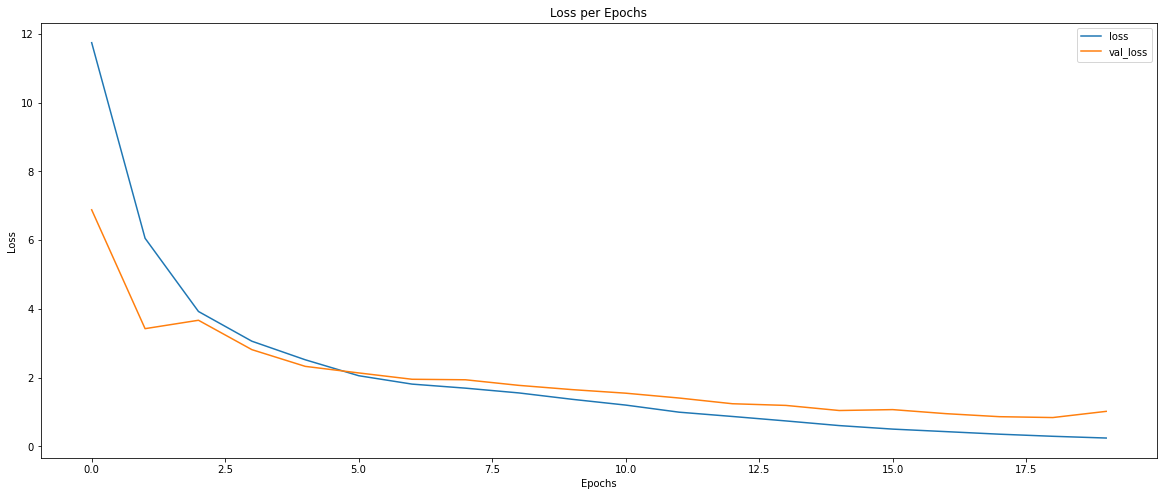

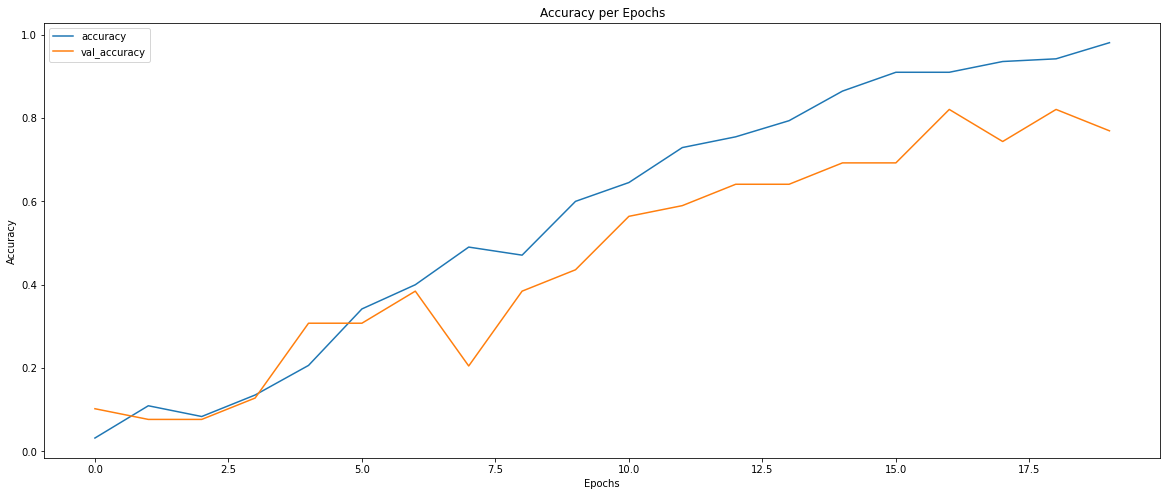

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(train_hist[['loss', 'val_loss']])
plt.legend(['loss', 'val_loss'])
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(train_hist[['accuracy', 'val_accuracy']])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
ytrue = np.argmax(ytest, axis=1)